In [1]:
!nvidia-smi

Mon Jun 20 20:32:53 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.103.01   Driver Version: 470.103.01   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro RTX 6000     Off  | 00000000:D8:00.0 Off |                  Off |
| 35%   32C    P8     7W / 260W |   6120MiB / 24220MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## T5 for RP Mod Dataset :)

In [2]:
import argparse
import glob
import os
import json
import time
import logging
import random
import re
from itertools import chain
from string import punctuation

import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize

import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl

# eval packages
import textwrap
from tqdm.auto import tqdm
from sklearn import metrics


from transformers import (
    AdamW,
    T5ForConditionalGeneration,
    T5Tokenizer,
    get_linear_schedule_with_warmup
)

def set_seed(seed):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

set_seed(42)

[nltk_data] Downloading package punkt to /home/dobby/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [3]:
class T5FineTuner(pl.LightningModule):
  def __init__(self, hparams, train_dataset, val_dataset):
    super(T5FineTuner, self).__init__()
    # self.hparams.save_hyperparameters(hparams)
    self.save_hyperparameters(hparams)
    
    self.model = T5ForConditionalGeneration.from_pretrained(hparams.model_name_or_path)
    self.tokenizer = T5Tokenizer.from_pretrained(hparams.tokenizer_name_or_path)
    self.train_dataset = train_dataset
    self.val_dataset = val_dataset
    
  def is_logger(self):
    return self.trainer.global_rank <= 0
  

  def forward(
      self, input_ids, attention_mask=None, decoder_input_ids=None, decoder_attention_mask=None, labels=None
  ):
    return self.model(
        input_ids,
        attention_mask=attention_mask,
        decoder_input_ids=decoder_input_ids,
        decoder_attention_mask=decoder_attention_mask,
        labels=labels,
        # lm_labels=lm_labels,
    )

  def _step(self, batch):
    labels = batch["target_ids"]
    labels[labels[:, :] == self.tokenizer.pad_token_id] = -100

    outputs = self(
        input_ids=batch["source_ids"],
        attention_mask=batch["source_mask"],
        labels=labels,
        # lm_labels=lm_labels,
        decoder_attention_mask=batch['target_mask']
    )

    loss = outputs[0]

    return loss
  
  def get_accuracy(self, batch):
    labels = batch["target_ids"]

    outs = self.model.generate(input_ids=batch["source_ids"], 
                                attention_mask=batch["source_mask"], 
                                max_length=2)

    dec = [self.tokenizer.decode(ids) for ids in outs]
    target = [self.tokenizer.decode(label) for label in labels]

    new_outputs = [s[6:] for s in dec]
    new_targets = [s[:-4] for s in target]

    accuracy_score = metrics.accuracy_score(new_targets, new_outputs)
    f1 = metrics.f1_score(new_targets, new_outputs, average="micro")
    # rec = metrics.recall_score(new_targets, new_outputs, average="micros")
    return accuracy_score, f1
  # def computer_accuracy(self):
  #   self.model.model.eval()

  def training_step(self, batch, batch_idx):
    loss = self._step(batch)
    self.log("train_loss", loss)
    return {"loss": loss}
  
  def training_epoch_end(self, outputs):
    avg_train_loss = torch.stack([x["loss"] for x in outputs]).mean()
    tensorboard_logs = {"avg_train_loss": avg_train_loss}
    self.log("avg_train_loss", avg_train_loss)
    
  def validation_step(self, batch, batch_idx):
    loss = self._step(batch)
    accuracy, f1 = torch.tensor(self.get_accuracy(batch))
    self.log("val_loss", loss, logger=True)
    self.log("val_accuracy", accuracy, logger=True)
    return {"val_loss": loss, "val_accuracy": accuracy}
  
  def validation_epoch_end(self, outputs):
    avg_loss = torch.stack([x["val_loss"] for x in outputs]).mean()
    avg_accuracy = torch.stack([x["val_accuracy"] for x in outputs]).mean()
    # tensorboard_logs = {"val_loss": avg_loss}
    self.log("avg_val_loss", avg_loss)
    self.log("avg_val_accuracy", avg_accuracy)
    # self.log("log", tensorboard_logs)
    # self.log("progress_bar", tensorboard_logs)
    # self.log({"avg_val_loss": avg_loss, 
    #           "log": tensorboard_logs,
    #           'progress_bar': tensorboard_logs}, logger=True, prog_bar=True)
    return {"avg_val_loss": avg_loss, "avg_val_accuracy": avg_accuracy}

  def configure_optimizers(self):
    "Prepare optimizer and schedule (linear warmup and decay)"

    model = self.model
    no_decay = ["bias", "LayerNorm.weight"]
    optimizer_grouped_parameters = [
        {
            "params": [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
            "weight_decay": self.hparams.weight_decay,
        },
        {
            "params": [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)],
            "weight_decay": 0.0,
        },
    ]
    optimizer = AdamW(optimizer_grouped_parameters, lr=self.hparams.learning_rate, eps=self.hparams.adam_epsilon)
    self.opt = optimizer
    return [optimizer]
  
  def optimizer_step(self, 
                      epoch,
                      batch_idx,
                      optimizer,
                      optimizer_idx,
                      second_order_closure=None,
                      on_tpu=None,
                      using_native_amp=None,
                      using_lbfgs=None):
    # if self.trainer.use_tpu:
    #   xm.optimizer_step(optimizer)
    # else:
    optimizer.step(closure=second_order_closure)
    optimizer.zero_grad()
    self.lr_scheduler.step()
  
  # def closure(self):
  #   return "closure"
  
  def get_tqdm_dict(self):
    tqdm_dict = {"loss": "{:.3f}".format(self.trainer.avg_loss), "lr": self.lr_scheduler.get_last_lr()[-1]}

    return tqdm_dict

  def train_dataloader(self):
    # train_dataset = get_dataset(tokenizer=self.tokenizer, type_path="train", args=self.hparams)
    dataloader = DataLoader(self.train_dataset, batch_size=self.hparams.train_batch_size, drop_last=True, shuffle=True, num_workers=4)
    t_total = (
        (len(dataloader.dataset) // (self.hparams.train_batch_size * max(1, self.hparams.n_gpu)))
        // self.hparams.gradient_accumulation_steps
        * float(self.hparams.num_train_epochs)
    )
    scheduler = get_linear_schedule_with_warmup(
        self.opt, num_warmup_steps=self.hparams.warmup_steps, num_training_steps=t_total
    )
    self.lr_scheduler = scheduler
    return dataloader

  def val_dataloader(self):
    # val_dataset = get_dataset(tokenizer=self.tokenizer, type_path="val", args=self.hparams)
    return DataLoader(self.val_dataset, batch_size=self.hparams.eval_batch_size, num_workers=4)

In [42]:
model = T5ForConditionalGeneration.from_pretrained(args.model_name_or_path)
val_dataloader = DataLoader(val_dataset, batch_size=8)
for batch in list(enumerate(val_dataloader))[:1]:
    print(batch[1].keys())
    outputs = model.generate(
        input_ids=batch[1]["source_ids"],
        attention_mask=batch[1]["source_mask"],
    )


dict_keys(['source_ids', 'source_mask', 'target_ids', 'target_mask'])


In [5]:
args_dict = dict(
    data_dir="", # path for data files
    output_dir="/GermanT5-RP-Mod/t5-efficient-oscar-german-small-el32/", # path to save the checkpoints
    model_name_or_path="GermanT5/t5-efficient-oscar-german-small-el32",
    tokenizer_name_or_path="GermanT5/t5-efficient-oscar-german-small-el32",
    dataset_name="RP-Mod",
    max_seq_length=512,
    learning_rate=1.9e-3,
    weight_decay=0.1,
    adam_epsilon=1e-8,
    warmup_steps=0,
    train_batch_size=8,
    eval_batch_size=8,
    num_train_epochs=10,
    gradient_accumulation_steps=16,
    n_gpu=1,
    early_stop_callback=False,
    fp_16=False, # if you want to enable 16-bit training then install apex and set this to true
    opt_level='O1', # you can find out more on optimisation levels here https://nvidia.github.io/apex/amp.html#opt-levels-and-properties
    max_grad_norm=0.5, # if you enable 16-bit training then set this to a sensible value, 0.5 is a good default
    seed=42,
)

In [6]:
args = argparse.Namespace(**args_dict)
args

Namespace(data_dir='', output_dir='/GermanT5-RP-Mod/t5-efficient-oscar-german-small-el32/', model_name_or_path='GermanT5/t5-efficient-oscar-german-small-el32', tokenizer_name_or_path='GermanT5/t5-efficient-oscar-german-small-el32', dataset_name='RP-Mod', max_seq_length=512, learning_rate=0.0019, weight_decay=0.1, adam_epsilon=1e-08, warmup_steps=0, train_batch_size=8, eval_batch_size=8, num_train_epochs=10, gradient_accumulation_steps=16, n_gpu=1, early_stop_callback=False, fp_16=False, opt_level='O1', max_grad_norm=0.5, seed=42)

### Set-up Wandb

In [9]:
WANDB_NOTEBOOK_NAME="t5_fine_tuning_rp_mod.ipynb"

In [10]:
from pytorch_lightning.loggers import WandbLogger
import wandb
wandb.finish()

# wandb_logger = WandbLogger(project=f"{args.dataset_name}-GermanT5-oscar-german-small-el32", 
#                             name=f"run-lr-{args.learning_rate}-wd-{args.weight_decay}" + 
#                             f"-gradient-accumulation-steps-{args.gradient_accumulation_steps}-no-swa")

wandb_logger = WandbLogger(project=f"{args.dataset_name}-GermanT5-oscar-german-small-el32", 
                            name="run-hyperparameter-tuning")

### Configure other training parameters

In [18]:
from pytorch_lightning.callbacks import RichProgressBar
from pytorch_lightning.callbacks import StochasticWeightAveraging
from ray.tune.integration.pytorch_lightning import TuneReportCallback

checkpoint_callback = pl.callbacks.ModelCheckpoint(
    dirpath=args.output_dir, filename="checkpoint", monitor="val_loss", mode="min", save_top_k=5
)

met = {"acc": "val_accuracy"}
raytuner_callback = TuneReportCallback(met, on="validation_end")

train_params = dict(
    accumulate_grad_batches=args.gradient_accumulation_steps,
    auto_lr_find=True,
    gpus=args.n_gpu,
    max_epochs=args.num_train_epochs,
    default_root_dir=f"/{args.max_seq_length}-RP-Mod/lr-{args.learning_rate}",
    # early_stop_callback=False,
    precision= 16 if args.fp_16 else 32,
    amp_level=args.opt_level,
    gradient_clip_val=args.max_grad_norm,
    # checkpoint_callback=checkpoint_callback,
    logger=wandb_logger,
    enable_checkpointing=checkpoint_callback,
    callbacks=[raytuner_callback],
    # callbacks=[LoggingCallback()],
    amp_backend="apex"
)

### Prepare RP-Mod Dataset for Use

In [7]:
tokenizer = T5Tokenizer.from_pretrained(args.model_name_or_path)

In [8]:
import csv
import random

def build_examples_from_files(csv_path):
    inputs = []
    targets = []

    REPLACE_NO_SPACE = re.compile("[.;:!\'?,\"()\[\]]")
    REPLACE_WITH_SPACE = re.compile("(<br\s*/><br\s*/>)|(\-)|(\/)")

    LABELS = ["unproblematisch", "problematisch"]

    with open(csv_path, encoding="utf-8") as f_source:
        reader = csv.DictReader(f_source)
        for row in reader:
            line = "classification: " + row["text"]
            line = REPLACE_NO_SPACE.sub("", line)
            line = REPLACE_WITH_SPACE.sub("", line)
            line = line

            target = LABELS[int(float(row['label']))]

            inputs.append(line)
            targets.append(target)
        
        temp = list(zip(inputs, targets))
        random.shuffle(temp)
        res1, res2 = zip(*temp)

        inputs, targets = list(res1), list(res2)

        val_inputs, val_targets = inputs[:1000], targets[:1000]
        test_inputs, test_targets = inputs[1000:2000], targets[1000:2000]
        train_inputs, train_targets = inputs[2000:], targets[2000:] 

    return train_inputs, train_targets, val_inputs, val_targets, test_inputs, test_targets

source = "./Datasets/RP-Mod-folds.csv"
train_inputs, train_targets, val_inputs, val_targets, test_inputs, test_targets = build_examples_from_files(source)
train_inputs[0], train_targets[0]

('classification Sag mal liebe RP was wollt ihr eigentlich Lieber am Ende jammern dass die Polizei versagt hat wenn dann doch ein Anschlag von Islamisten passiert Diese linksgrüne MainstreamMeinungsmache ist wirklich furchtbar Das hat doch nichts mehr mit vernünftigen Journalismus zu tun Ein richtiger Journalist wägt bei Themen vernünftig ab ist kritisch führt Vor und Nachteile auf aber bringt auf keinen Fall zuerst einmal seine persönliche Einstellung zu Papiert',
 'unproblematisch')

In [9]:
import csv
#TODO: reorganize this as a lightning data module?
class RPDataset(Dataset):
    def __init__(self, tokenizer, inputs, outputs, max_len=512):
        self.max_len = max_len
        self.tokenizer = tokenizer

        self.inputs = inputs
        self.outputs = outputs

        self.tokenized_inputs = tokenizer.batch_encode_plus(
            inputs, max_length=max_len, padding=True, truncation=True, return_tensors="pt"
        )
        self.tokenized_targets = tokenizer.batch_encode_plus(
            outputs, max_length=2, padding=True, truncation=True, return_tensors="pt"
        )
    
    def __len__(self):
        return len(self.inputs)
    
    def __getitem__(self, index):
        # tokenize input and output
        
        source_ids = self.tokenized_inputs["input_ids"][index].squeeze()
        target_ids = self.tokenized_targets["input_ids"][index].squeeze()

        src_mask    = self.tokenized_inputs["attention_mask"][index].squeeze()  # might need to squeeze
        target_mask = self.tokenized_targets["attention_mask"][index].squeeze()  # might need to squeeze

        return {"source_ids": source_ids, "source_mask": src_mask, "target_ids": target_ids, "target_mask": target_mask}
        

In [10]:
train_dataset = RPDataset(tokenizer, train_inputs, train_targets)
val_dataset = RPDataset(tokenizer, val_inputs, val_targets)


In [56]:
len(train_dataset)

12282

In [11]:
test_dataset = RPDataset(tokenizer, test_inputs, test_targets)

In [17]:
data = train_dataset.__getitem__(50)
print(tokenizer.decode(data['source_ids']))
print(tokenizer.decode(data['target_ids']))

classification Richtig so Der öffentliche Raum gehört nicht nur den Autobesitzern die so oder so schon viel zu viel Raum illegal durch Gehwerk oder Radwegparken nehmen</s> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
unproblematisch</s>


### Hyperparameter Search

In [49]:
from ray.tune.integration.wandb import wandb_mixin

@wandb_mixin
def train_rp(config, num_epochs=4):
    model = T5FineTuner(args, train_dataset, val_dataset)
    tuning_params = dict(
        accumulate_grad_batches=args.gradient_accumulation_steps,
        auto_lr_find=True,
        gpus=args.n_gpu,
        #TODO: change num_epochs
        max_epochs=num_epochs,
        default_root_dir=f"/{args.max_seq_length}-RP-Mod/lr-{args.learning_rate}",
        # early_stop_callback=False,
        precision= 16 if args.fp_16 else 32,
        amp_level=args.opt_level,
        gradient_clip_val=args.max_grad_norm,
        # checkpoint_callback=checkpoint_callback,
        logger=wandb_logger,
        enable_checkpointing=checkpoint_callback,
        callbacks=[raytuner_callback],
        # callbacks=[LoggingCallback()],
        amp_backend="apex"
    )
    trainer = pl.Trainer(**tuning_params)
    # do I need to update the train_params here with another value for the callback
    trainer.fit(model)

In [51]:
from ray import tune
from ray.tune.logger import DEFAULT_LOGGERS
from ray.tune.integration.wandb import WandbLogger

num_epochs = 10

config = {
    "learning_rate": tune.loguniform(1e-4, 5e-3), 
    "weight_decay": tune.choice([0.01, 0.1]),
    # wandb configuration
    "wandb": {
            "project": "Optimization_Project",
            # "log_config": True
        }
}

trainable = tune.with_parameters(
    train_rp
)

analysis = tune.run(
    trainable,
    resources_per_trial={
        "cpu":1,
        "gpu":1
    },
    metric="acc",
    mode="min",
    config=config,
    name="tune_rp",
    # callbacks=[wandb_logger]
)

print(analysis.best_config)

2022-06-20 12:00:07,792	WARNING worker.py:1404 -- Warning: The actor ImplicitFunc is very large (32 MiB). Check that its definition is not implicitly capturing a large array or other object in scope. Tip: use ray.put() to put large objects in the Ray object store.
2022-06-20 12:00:07,873	WARNING util.py:214 -- The `start_trial` operation took 0.564 s, which may be a performance bottleneck.
(raylet) /usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (3.0.4) doesn't match a supported version!
(raylet)   warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
(raylet) /usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (3.0.4) doesn't match a supported version!
(raylet)   warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
(ImplicitFunc pid=17844) 2022-06-20 12:00:11,109	INFO wandb.py:172 -- Already logged into W&B.
(ImplicitFunc pid=17

== Status ==
Current time: 2022-06-20 12:00:12 (running for 00:00:05.32)
Memory usage on this node: 26.9/376.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/8 CPUs, 1.0/1 GPUs, 0.0/34.4 GiB heap, 0.0/17.2 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/dobby/ray_results/tune_rp
Number of trials: 1/1 (1 RUNNING)
+----------------------+----------+------------------+-----------------+----------------+
| Trial name           | status   | loc              |   learning_rate |   weight_decay |
|----------------------+----------+------------------+-----------------+----------------|
| train_rp_86c32_00000 | RUNNING  | 172.17.0.5:17844 |     0.000368944 |            0.1 |
+----------------------+----------+------------------+-----------------+----------------+




(ImplicitFunc pid=17844) wandb: Tracking run with wandb version 0.12.18
(ImplicitFunc pid=17844) wandb: Run data is saved locally in /home/dobby/ray_results/tune_rp/train_rp_86c32_00000_0_learning_rate=0.0004,weight_decay=0.1000_2022-06-20_12-00-07/wandb/run-20220620_120011-86c32_00000
(ImplicitFunc pid=17844) wandb: Run `wandb offline` to turn off syncing.
(ImplicitFunc pid=17844) wandb: Syncing run train_rp_86c32_00000
(ImplicitFunc pid=17844) wandb: ⭐️ View project at https://wandb.ai/isadoraw/Optimization_Project
(ImplicitFunc pid=17844) wandb: 🚀 View run at https://wandb.ai/isadoraw/Optimization_Project/runs/86c32_00000
(train_rp pid=17844) GPU available: True, used: True
(train_rp pid=17844) TPU available: False, using: 0 TPU cores
(train_rp pid=17844) IPU available: False, using: 0 IPUs
(train_rp pid=17844) HPU available: False, using: 0 HPUs
(train_rp pid=17844) /home/dobby/.local/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:117: UserWarning:

== Status ==
Current time: 2022-06-20 12:00:17 (running for 00:00:10.32)
Memory usage on this node: 28.1/376.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/8 CPUs, 1.0/1 GPUs, 0.0/34.4 GiB heap, 0.0/17.2 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/dobby/ray_results/tune_rp
Number of trials: 1/1 (1 RUNNING)
+----------------------+----------+------------------+-----------------+----------------+
| Trial name           | status   | loc              |   learning_rate |   weight_decay |
|----------------------+----------+------------------+-----------------+----------------|
| train_rp_86c32_00000 | RUNNING  | 172.17.0.5:17844 |     0.000368944 |            0.1 |
+----------------------+----------+------------------+-----------------+----------------+




(train_rp pid=17844) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(train_rp pid=17844) /home/dobby/.local/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(train_rp pid=17844)   warnings.warn(
(train_rp pid=17844) 
(train_rp pid=17844)   | Name  | Type                       | Params
(train_rp pid=17844) -----------------------------------------------------
(train_rp pid=17844) 0 | model | T5ForConditionalGeneration | 142 M 
(train_rp pid=17844) -----------------------------------------------------
(train_rp pid=17844) 142 M     Trainable params
(train_rp pid=17844) 0         Non-trainable params
(train_rp pid=17844) 142 M     Total params
(train_rp pid=17844) 569.289   Total estimated model params size (MB)
(train_rp pid=17844) /home/dobby/.local/lib/python3.9/s

Sanity Checking: 0it [00:00, ?it/s]
Epoch 0:   0%|          | 2/1660 [00:00<09:59,  2.76it/s, loss=21.3, v_num=0000]
== Status ==
Current time: 2022-06-20 12:00:22 (running for 00:00:15.33)
Memory usage on this node: 29.7/376.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/8 CPUs, 1.0/1 GPUs, 0.0/34.4 GiB heap, 0.0/17.2 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/dobby/ray_results/tune_rp
Number of trials: 1/1 (1 RUNNING)
+----------------------+----------+------------------+-----------------+----------------+
| Trial name           | status   | loc              |   learning_rate |   weight_decay |
|----------------------+----------+------------------+-----------------+----------------|
| train_rp_86c32_00000 | RUNNING  | 172.17.0.5:17844 |     0.000368944 |            0.1 |
+----------------------+----------+------------------+-----------------+----------------+


Epoch 0:   3%|▎         | 44/1660 [00:05<03:27,  7.79it/s, loss=12.5, v_num=0000]
== S

2022-06-20 12:03:36,635	ERROR trial_runner.py:886 -- Trial train_rp_86c32_00000: Error processing event.
NoneType: None
(train_rp pid=17844) 2022-06-20 12:03:36,621	ERROR function_runner.py:286 -- Runner Thread raised error.
(train_rp pid=17844) Traceback (most recent call last):
(train_rp pid=17844)   File "/home/dobby/.local/lib/python3.9/site-packages/ray/tune/function_runner.py", line 277, in run
(train_rp pid=17844)     self._entrypoint()
(train_rp pid=17844)   File "/home/dobby/.local/lib/python3.9/site-packages/ray/tune/function_runner.py", line 349, in entrypoint
(train_rp pid=17844)     return self._trainable_func(
(train_rp pid=17844)   File "/home/dobby/.local/lib/python3.9/site-packages/ray/util/tracing/tracing_helper.py", line 462, in _resume_span
(train_rp pid=17844)     return method(self, *_args, **_kwargs)
(train_rp pid=17844)   File "/home/dobby/.local/lib/python3.9/site-packages/ray/tune/function_runner.py", line 645, in _trainable_func
(train_rp pid=17844)     outpu

Result for train_rp_86c32_00000:
  acc: 0.509
  date: 2022-06-20_12-03-34
  done: false
  experiment_id: c6f5e25ceb2844f99760bc29b12a9a21
  experiment_tag: 0_learning_rate=0.0004,weight_decay=0.1000
  hostname: facd02a90c00
  iterations_since_restore: 1
  node_ip: 172.17.0.5
  pid: 17844
  time_since_restore: 202.64174103736877
  time_this_iter_s: 202.64174103736877
  time_total_s: 202.64174103736877
  timestamp: 1655726614
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 86c32_00000
  warmup_time: 1.069762945175171
  
== Status ==
Current time: 2022-06-20 12:03:36 (running for 00:03:29.79)
Memory usage on this node: 31.4/376.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/8 CPUs, 0/1 GPUs, 0.0/34.4 GiB heap, 0.0/17.2 GiB objects (0.0/1.0 accelerator_type:RTX)
Current best trial: 86c32_00000 with acc=0.509 and parameters={'learning_rate': 0.00036894439804188814, 'weight_decay': 0.1}
Result logdir: /home/dobby/ray_results/tune_rp
Number of trials: 1/1 (1 ER

(train_rp pid=17844) wandb: Waiting for W&B process to finish... (success).
(train_rp pid=17844) wandb: - 0.001 MB of 0.001 MB uploaded (0.000 MB deduped)
(train_rp pid=17844) wandb: \ 0.001 MB of 0.001 MB uploaded (0.000 MB deduped)
(train_rp pid=17844) wandb: | 0.001 MB of 0.010 MB uploaded (0.000 MB deduped)
(train_rp pid=17844) wandb: / 0.001 MB of 0.010 MB uploaded (0.000 MB deduped)
(train_rp pid=17844) wandb: - 0.001 MB of 0.010 MB uploaded (0.000 MB deduped)
(train_rp pid=17844) wandb: \ 0.010 MB of 0.010 MB uploaded (0.000 MB deduped)
(train_rp pid=17844) wandb: | 0.010 MB of 0.010 MB uploaded (0.000 MB deduped)
(train_rp pid=17844) wandb: / 0.010 MB of 0.010 MB uploaded (0.000 MB deduped)
(train_rp pid=17844) wandb: - 0.010 MB of 0.010 MB uploaded (0.000 MB deduped)
(train_rp pid=17844) wandb: \ 0.010 MB of 0.010 MB uploaded (0.000 MB deduped)
(train_rp pid=17844) wandb: | 0.010 MB of 0.010 MB uploaded (0.000 MB deduped)
(train_rp pid=17844) wandb: / 0.010 MB of 0.010 MB uplo

TuneError: ('Trials did not complete', [train_rp_86c32_00000])

### Less fancy hyperparameter search :) 

In [13]:
from pytorch_lightning.loggers import WandbLogger
import wandb
possible_learning_rates = [2e-3, 9e-4]
possible_weight_decays = [0.1, 0.01, 1]

checkpoint_callback = pl.callbacks.ModelCheckpoint(
    dirpath=args.output_dir, filename="checkpoint", monitor="val_accuracy", mode="max", save_top_k=5
)

for lr in possible_learning_rates:
    for wd in possible_weight_decays:
        wandb.finish()
        wandb_logger = WandbLogger(project=f"{args.dataset_name}-GermanT5-oscar-german-small-el32-hyperparameter-tuning", 
        name=f"learning_rate-{lr}-weight_decay-{wd}")

        args_dict = dict(
            data_dir="", # path for data files
            output_dir="/GermanT5-RP-Mod/t5-efficient-oscar-german-small-el32/", # path to save the checkpoints
            model_name_or_path="GermanT5/t5-efficient-oscar-german-small-el32",
            tokenizer_name_or_path="GermanT5/t5-efficient-oscar-german-small-el32",
            dataset_name="RP-Mod",
            max_seq_length=512,
            learning_rate=lr,
            weight_decay=wd,
            adam_epsilon=1e-8,
            warmup_steps=0,
            train_batch_size=8,
            eval_batch_size=8,
            num_train_epochs=10,
            gradient_accumulation_steps=16,
            n_gpu=1,
            early_stop_callback=False,
            fp_16=False, # if you want to enable 16-bit training then install apex and set this to true
            opt_level='O1', # you can find out more on optimisation levels here https://nvidia.github.io/apex/amp.html#opt-levels-and-properties
            max_grad_norm=0.5, # if you enable 16-bit training then set this to a sensible value, 0.5 is a good default
            seed=42,
        )
        args = argparse.Namespace(**args_dict)

        train_params = dict(
            accumulate_grad_batches=args.gradient_accumulation_steps,
            auto_lr_find=True,
            gpus=args.n_gpu,
            max_epochs=args.num_train_epochs,
            default_root_dir=f"/home/dobby/RP-Mod/t5-efficient-oscar-german-small-el32",
            # early_stop_callback=False,
            precision= 16 if args.fp_16 else 32,
            amp_level=args.opt_level,
            gradient_clip_val=args.max_grad_norm,
            # checkpoint_callback=checkpoint_callback,
            logger=wandb_logger,
            enable_checkpointing=checkpoint_callback,
            callbacks=[raytuner_callback],
            # callbacks=[LoggingCallback()],
            amp_backend="apex"
        )

        model = T5FineTuner(args, train_dataset, val_dataset)
        trainer = pl.Trainer(**train_params)

        trainer.fit(model)


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
wandb: Currently logged in as: isadoraw. Use `wandb login --relogin` to force relogin


NameError: name 'checkpoint_callback' is not defined

### Begin Training

In [87]:
model = T5FineTuner(args, train_dataset, val_dataset)
trainer = pl.Trainer(**train_params)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [86]:
args

Namespace(data_dir='', output_dir='/GermanT5-RP-Mod/t5-efficient-oscar-german-small-el32/', model_name_or_path='GermanT5/t5-efficient-oscar-german-small-el32', tokenizer_name_or_path='GermanT5/t5-efficient-oscar-german-small-el32', dataset_name='RP-Mod', max_seq_length=512, learning_rate=0.0019, weight_decay=0.1, adam_epsilon=1e-08, warmup_steps=0, train_batch_size=8, eval_batch_size=8, num_train_epochs=10, gradient_accumulation_steps=16, n_gpu=1, early_stop_callback=False, fp_16=False, opt_level='O1', max_grad_norm=0.5, seed=42)

In [88]:
trainer.fit(model)

/home/dobby/.local/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:117: UserWarning: When using `Trainer(accumulate_grad_batches != 1)` and overriding `LightningModule.optimizer_{step,zero_grad}`, the hooks will not be called on every batch (rather, they are called on every optimization step).
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/dobby/.local/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(

  | Name  | Type                       | Params
-----------------------------------------------------
0 | model | T5ForConditionalGeneration | 142 M 
-----------------------------------------------------
142 M     Trainable params
0         Non-trainable params
142 M     Total params
569.289   

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

/home/dobby/.local/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:151: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=<pytorch_lightning.callbacks.model_checkpoint.ModelCheckpoint object at 0x7f1fa979cc10>)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=<pytorch_lightning.callbacks.model_checkpoint.ModelCheckpoint object at 0x7f1fa979cc10>)`.
  rank_zero_deprecation(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/dobby/.local/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:117: UserWarning: When using `Trainer(accumulate_grad_batches != 1)` and overriding `LightningModule.optimizer_{step,zero_grad}`, the hooks will not be called on every batch (rather, they are called on every optimization step).
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VI

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restoring states from the checkpoint path at /home/dobby/.lr_find_eabaf0f2-c58f-481b-8134-e84ef263372d.ckpt


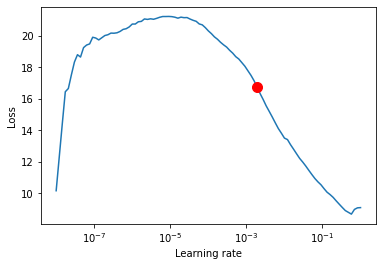

In [62]:
model = T5FineTuner(args, train_dataset, val_dataset)
trainer = pl.Trainer(**train_params)


lr_finder = trainer.tuner.lr_find(model)

# Results can be found in
# print(lr_finder.results)

# Plot with
fig = lr_finder.plot(suggest=True)
fig.show()


In [49]:
new_lr

NameError: name 'new_lr' is not defined

In [63]:
new_lr = lr_finder.suggestion()

# model.hparams.learning_rate = new_lr

# trainer.fit(model)

In [64]:
new_lr

0.0019054607179632484

In [112]:
trainer.fit(model)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                       | Params
-----------------------------------------------------
0 | model | T5ForConditionalGeneration | 222 M 
-----------------------------------------------------
222 M     Trainable params
0         Non-trainable params
222 M     Total params
891.614   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/home/dobby/.local/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:286: UserWarning: The ``compute`` method of metric _ResultMetric was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  rank_zero_warn(


Validation: 0it [00:00, ?it/s]

In [69]:
model.model.save_pretrained('t5_german_small_rp_mod_3')

### Eval 

In [70]:
import textwrap
from tqdm.auto import tqdm
from sklearn import metrics

In [71]:
dataset = test_dataset
loader = DataLoader(dataset, batch_size=32, shuffle=True)

it = iter(loader)

batch = next(it)
batch["source_ids"].shape

torch.Size([32, 113])

In [72]:
batch["source_ids"].cuda()

tensor([[23574, 22822,  2940,  ...,     0,     0,     0],
        [23574, 22822,   114,  ...,     0,     0,     0],
        [23574, 22822,     8,  ...,     0,     0,     0],
        ...,
        [23574, 22822,  2903,  ...,     0,     0,     0],
        [23574, 22822,  6428,  ...,     0,     0,     0],
        [23574, 22822,  1631,  ...,     0,     0,     0]], device='cuda:0')

In [73]:
outs = model.model.generate(input_ids=batch['source_ids'], 
                              attention_mask=batch['source_mask'], 
                              max_length=2)

dec = [tokenizer.decode(ids) for ids in outs]

texts = [tokenizer.decode(ids) for ids in batch['source_ids']]
targets = [tokenizer.decode(ids) for ids in batch['target_ids']]

In [156]:
len(texts)

8

In [74]:
for i in range(8):
    lines = textwrap.wrap("Review:\n%s\n" % texts[i], width=100)
    print("\n".join(lines))
    print("\nActual sentiment: %s" % targets[i])
    print("Predicted sentiment: %s" % dec[i])
    print("=====================================================================\n")

Review: classification Sollte man das nicht auch für den einen oder anderen auffälligen Fan
einführen</s> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
<pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
<pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
<pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
<pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
<pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
<pad> <pad>

Actual sentiment: problematisch</s>
Predicted sentiment: <pad> unproblematisch

Review: classification Wir sollten ganz schnell den eisernen Vorhang wieder hochziehen Ein Großteil
der Osteuropäer hat aus der kommunistischen Ära nichts gelernt se können mit der ihnen geschenkten
Freiheit einfach nicht umgehen</s> <pa

In [75]:
loader = DataLoader(dataset, batch_size=32, num_workers=4)
model.model.eval()
outputs = []
targets = []
for batch in tqdm(loader):
  # outs = model.model.generate(input_ids=batch['source_ids'].cuda(), 
  #                             attention_mask=batch['source_mask'].cuda(), 
  #                             max_length=2)

  outs = model.model.generate(input_ids=batch['source_ids'], 
                              attention_mask=batch['source_mask'], 
                              max_length=2)

  dec = [tokenizer.decode(ids) for ids in outs]
  target = [tokenizer.decode(ids) for ids in batch["target_ids"]]
  
  outputs.extend(dec)
  targets.extend(target)

  0%|          | 0/32 [00:00<?, ?it/s]

In [76]:
new_outputs = [s[6:] for s in outputs]
new_targets = [s[:-4] for s in targets]

len(new_outputs), len(new_targets)

(1000, 1000)

In [77]:
for i, out in enumerate(new_outputs):
  if out not in ['problematisch', 'unproblematisch']:
    print(i, 'detected invalid prediction')
    

In [78]:
metrics.accuracy_score(new_targets, new_outputs)

0.688

In [79]:
len(train_dataset)

12282

In [80]:
print(metrics.classification_report(new_targets, new_outputs))

                 precision    recall  f1-score   support

  problematisch       0.67      0.82      0.74       530
unproblematisch       0.73      0.53      0.62       470

       accuracy                           0.69      1000
      macro avg       0.70      0.68      0.68      1000
   weighted avg       0.70      0.69      0.68      1000



In [81]:
def compute_accuracy(dataset, model):
    loader = DataLoader(dataset, batch_size=32, shuffle=True)

    it = iter(loader)

    batch = next(it)
    batch["source_ids"].shape

    model.model.eval()
    outputs = []
    targets = []
    for batch in tqdm(loader):

        outs = model.model.generate(input_ids=batch['source_ids'], 
                                    attention_mask=batch['source_mask'], 
                                    max_length=2)

        dec = [tokenizer.decode(ids) for ids in outs]
        target = [tokenizer.decode(ids) for ids in batch["target_ids"]]
        
        outputs.extend(dec)
        targets.extend(target)
    
    new_outputs = [s[6:] for s in outputs]
    new_targets = [s[:-4] for s in targets]

    for i, out in enumerate(new_outputs):
        if out not in ['problematisch', 'unproblematisch']:
            print(i, 'detected invalid prediction')
    
    print(metrics.accuracy_score(new_targets, new_outputs))

    print(metrics.classification_report(new_targets, new_outputs))

    return new_targets, new_outputs


targets, outputs = compute_accuracy(test_dataset, model)

  0%|          | 0/32 [00:00<?, ?it/s]

0.736
                 precision    recall  f1-score   support

  problematisch       0.74      0.75      0.74       512
unproblematisch       0.73      0.72      0.73       488

       accuracy                           0.74      1000
      macro avg       0.74      0.74      0.74      1000
   weighted avg       0.74      0.74      0.74      1000



In [ ]:
pr_curve = metrics.precision_recall_curve(targets, outputs, )

In [80]:
compute_accuracy(test_dataset, model)

  0%|          | 0/32 [00:00<?, ?it/s]

0.736
                 precision    recall  f1-score   support

  problematisch       0.74      0.75      0.74       512
unproblematisch       0.73      0.72      0.73       488

       accuracy                           0.74      1000
      macro avg       0.74      0.74      0.74      1000
   weighted avg       0.74      0.74      0.74      1000



UFuncTypeError: ufunc 'subtract' did not contain a loop with signature matching types (dtype('<U15'), dtype('<U15')) -> None

### Attempt to Retrieve Checkpoint

In [75]:
checkpoint_callback.best_model_path

''

In [ ]:
# go to this link: https://pytorch-lightning.readthedocs.io/en/stable/common/checkpointing.html

new_model = T5FineTuner.load_from_checkpoint(checkpoint_path="")